# Classification des races de chiens (Top 10)
Ce notebook entraîne un CNN sur les 10 races de chiens les plus représentées du Stanford Dogs Dataset.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam, SGD, RMSprop
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg_preprocess
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as inception_preprocess
from tensorflow.data.experimental import load

import time
import albumentations as A
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from sklearn.model_selection import train_test_split, KFold

2025-06-08 16:51:47.180123: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749401507.366367      19 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749401507.421442      19 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.8' (you have '2.0.5'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [2]:
def resnet_simple_preprocess(x, y):
    x = x * 255.0
    x = resnet_preprocess(x)
    return x, y

def vgg_simple_preprocess(x, y):
    x = x * 255.0
    x = vgg_preprocess(x)
    return x, y

def inception_simple_preprocess(x, y):
    x = x * 255.0
    x = inception_preprocess(x)
    return x, y

In [3]:
raw_dir = "/kaggle/input/stanford-dogs-dataset/Images"

# Comptage du nombre d'images par race
counts = {}
for breed in os.listdir(raw_dir):
    path = os.path.join(raw_dir, breed)
    if os.path.isdir(path):
        counts[breed] = len(os.listdir(path))

# On trie par fréquence et on garde les 10 premières
top10 = sorted(counts, key=counts.get, reverse=True)[:10]
print("Top 10 des races :", top10)

Top 10 des races : ['n02085936-Maltese_dog', 'n02088094-Afghan_hound', 'n02092002-Scottish_deerhound', 'n02112018-Pomeranian', 'n02107683-Bernese_mountain_dog', 'n02111889-Samoyed', 'n02090721-Irish_wolfhound', 'n02086240-Shih-Tzu', 'n02111500-Great_Pyrenees', 'n02111129-Leonberg']


In [4]:
batch_size = 32
num_classes = len(top10)
TARGET_SIZE = 224

In [5]:
train_spec = (
    tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
    tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None)
)

val_spec = (
    tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 
    tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None)
)

test_spec = (
    tf.TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), 
    tf.TensorSpec(shape=(None,), dtype=tf.int32, name=None)
)

In [6]:
train_ds = load("/kaggle/input/bigot-benjamin-1-notebook-pr-traitement-052025/train_ds", element_spec=train_spec)
val_ds = load("/kaggle/input/bigot-benjamin-1-notebook-pr-traitement-052025/val_ds", element_spec=train_spec)
test_ds = load("/kaggle/input/bigot-benjamin-1-notebook-pr-traitement-052025/test_ds", element_spec=train_spec)

I0000 00:00:1749401527.717308      19 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [7]:
train_ds_resnet = train_ds.map(resnet_simple_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_resnet = val_ds.map(resnet_simple_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_resnet = test_ds.map(resnet_simple_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_vgg = train_ds.map(vgg_simple_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_vgg = val_ds.map(vgg_simple_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_vgg = test_ds.map(vgg_simple_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)

train_ds_inception = train_ds.map(inception_simple_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
val_ds_inception = val_ds.map(inception_simple_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)
test_ds_inception = test_ds.map(inception_simple_preprocess,   num_parallel_calls=tf.data.AUTOTUNE)

## Définition du modèle CNN

In [8]:
def build_resnet():
    base = ResNet50(weights='imagenet',
                 include_top=False,
                 input_shape=(224,224,3))
    
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 4) Créer le modèle final
    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
    
build_resnet().summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 23,608,202 (90.06 MB)

 Trainable params: 23,555,082 (89.86 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [9]:
def build_vgg():
    base = VGG16(weights='imagenet',
                 include_top=False,
                 input_shape=(224,224,3))
    
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 4) Créer le modèle final
    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
    
build_vgg().summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 3s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 512)                 │              

 Total params: 14,719,818 (56.15 MB)

 Trainable params: 14,719,818 (56.15 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
def build_inception():
    base = InceptionV3(weights='imagenet',
                 include_top=False,
                 input_shape=(224,224,3))
    
    x = GlobalAveragePooling2D()(base.output)
    x = Dropout(0.5)(x)
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # 4) Créer le modèle final
    model = Model(inputs=base.input, outputs=outputs)
    model.compile(
        optimizer=Adam(learning_rate=1e-5),
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model
    
build_inception().summary()

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d (Conv2D)           │ (None, 111, 111, 32)   │            864 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization       │ (None, 111, 111, 32)   │             96 │ conv2d[0][0]           │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation (Activation)   │ (None, 111, 111, 32)   │              0 │ batch_normalization[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_1 (Conv2D)         │ (None, 109, 109, 32)   │          9,216 │ activation[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_1     │ (None, 109, 109, 32)   │             96 │ conv2d_1[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_1 (Activation) │ (None, 109, 109, 32)   │              0 │ batch_normalization_1… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_2 (Conv2D)         │ (None, 109, 109, 64)   │         18,432 │ activation_1[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_2     │ (None, 109, 109, 64)   │            192 │ conv2d_2[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_2 (Activation) │ (None, 109, 109, 64)   │              0 │ batch_normalization_2… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ max_pooling2d             │ (None, 54, 54, 64)     │              0 │ activation_2[0][0]     │
│ (MaxPooling2D)            │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_3 (Conv2D)         │ (None, 54, 54, 80)     │          5,120 │ max_pooling2d[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_3     │ (None, 54, 54, 80)     │            240 │ conv2d_3[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ activation_3 (Activation) │ (None, 54, 54, 80)     │              0 │ batch_normalization_3… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2d_4 (Conv2D)         │ (None, 52, 52, 192)    │        138,240 │ activation_3[0][0]     │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ batch_normalization_4     │ (None, 52, 52, 192)    │            576 │ conv2d_4[0][0]         │
│ (BatchNormalization)      │                        │                │                        │
├──────────────────────

 Total params: 21,823,274 (83.25 MB)

 Trainable params: 21,788,842 (83.12 MB)

 Non-trainable params: 34,432 (134.50 KB)

In [11]:
resnet = build_resnet()
vgg = build_vgg()
inception = build_inception()

## Entraînement du modèle

In [12]:
start = time.time()

history_resnet = resnet.fit(
    train_ds_resnet,
    validation_data=val_ds_resnet,
    epochs=30,
)
end = time.time()

time_resnet = end - start
print(f"ResNet : Temps total : {end - start:.2f} secondes")

Epoch 1/30


I0000 00:00:1749401599.126217      60 service.cc:148] XLA service 0x7d66c81af710 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1749401599.126954      60 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1749401603.975082      60 cuda_dnn.cc:529] Loaded cuDNN version 90300


 1/42 ━━━━━━━━━━━━━━━━━━━━ 49:41 73s/step - accuracy: 0.1875 - loss: 3.2350

I0000 00:00:1749401623.798971      60 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


42/42 ━━━━━━━━━━━━━━━━━━━━ 109s 891ms/step - accuracy: 0.1377 - loss: 2.9279 - val_accuracy: 0.1991 - val_loss: 2.4632
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.2647 - loss: 2.1494 - val_accuracy: 0.3781 - val_loss: 1.8020
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.4395 - loss: 1.6899 - val_accuracy: 0.5190 - val_loss: 1.4102
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.5628 - loss: 1.3199 - val_accuracy: 0.6309 - val_loss: 1.1343
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.7007 - loss: 1.0290 - val_accuracy: 0.6957 - val_loss: 0.9578
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 180ms/step - accuracy: 0.7784 - loss: 0.7966 - val_accuracy: 0.7293 - val_loss: 0.8484
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 182ms/step - accuracy: 0.8711 - loss: 0.6149 - val_accuracy: 0.7315 - val_loss: 0.8000
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 8s 181ms/step - accuracy: 0.8971 - loss: 0.4767 - val_accuracy: 0.7427 - va

In [13]:
start = time.time()

history_vgg = vgg.fit(
    train_ds_vgg,
    validation_data=val_ds_vgg,
    epochs=30,
)
end = time.time()

time_vgg = end - start
print(f"VGG : Temps total : {end - start:.2f} secondes")

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 65s 966ms/step - accuracy: 0.1176 - loss: 18.3624 - val_accuracy: 0.1051 - val_loss: 2.9420
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.1026 - loss: 2.5853 - val_accuracy: 0.1253 - val_loss: 2.3894
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.1036 - loss: 2.3519 - val_accuracy: 0.1186 - val_loss: 2.3383
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.1197 - loss: 2.3178 - val_accuracy: 0.1096 - val_loss: 2.3246
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.1008 - loss: 2.3026 - val_accuracy: 0.1230 - val_loss: 2.3108
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.1134 - loss: 2.2792 - val_accuracy: 0.1230 - val_loss: 2.3059
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 251ms/step - accuracy: 0.1326 - loss: 2.2607 - val_accuracy: 0.1342 - val_loss: 2.3009
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 11s 252ms/step - accuracy: 0.1292 - loss: 2.2669 - val_acc

In [14]:
start = time.time()

history_inception = inception.fit(
    train_ds_inception,
    validation_data=val_ds_inception,
    epochs=30,
)
end = time.time()

time_inception = end - start
print(f"Inception : Temps total : {end - start:.2f} secondes")

Epoch 1/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 139s 1s/step - accuracy: 0.1058 - loss: 2.6134 - val_accuracy: 0.3400 - val_loss: 2.0907
Epoch 2/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.3526 - loss: 1.8858 - val_accuracy: 0.5928 - val_loss: 1.4139
Epoch 3/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.5701 - loss: 1.4473 - val_accuracy: 0.7383 - val_loss: 1.0925
Epoch 4/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.7470 - loss: 1.1118 - val_accuracy: 0.7808 - val_loss: 0.9152
Epoch 5/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.8294 - loss: 0.8986 - val_accuracy: 0.8143 - val_loss: 0.8080
Epoch 6/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9101 - loss: 0.6767 - val_accuracy: 0.8277 - val_loss: 0.7416
Epoch 7/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9310 - loss: 0.5721 - val_accuracy: 0.8367 - val_loss: 0.6992
Epoch 8/30
42/42 ━━━━━━━━━━━━━━━━━━━━ 7s 158ms/step - accuracy: 0.9729 - loss: 0.4387 - val_accuracy: 0.8

## Évaluation

In [15]:
loss_resnet, acc_resnet = resnet.evaluate(test_ds_resnet)
print("ResNet 50 :")
print(f"Validation loss  = {loss_resnet:.3f}")
print(f"Validation accuracy = {acc_resnet:.3%}")
print(f"Temps d'entrainement  = {time_resnet:.3f}")

loss_vgg, acc_vgg = vgg.evaluate(test_ds_vgg)
print("VGG 16 :")
print(f"Validation loss  = {loss_vgg:.3f}")
print(f"Validation accuracy = {acc_vgg:.3%}")
print(f"Temps d'entrainement  = {time_vgg:.3f}")

loss_inception, acc_inception = inception.evaluate(test_ds_inception)
print("Inception V3 :")
print(f"Validation loss  = {loss_inception:.3f}")
print(f"Validation accuracy = {acc_inception:.3%}")
print(f"Temps d'entrainement  = {time_inception:.3f}")

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 126ms/step - accuracy: 0.8601 - loss: 0.4845
ResNet 50 :
Validation loss  = 0.541
Validation accuracy = 83.221%
Temps d'entrainement  = 332.950
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - accuracy: 0.4014 - loss: 2.3695
VGG 16 :
Validation loss  = 2.240
Validation accuracy = 42.282%
Temps d'entrainement  = 375.006
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - accuracy: 0.8295 - loss: 0.4932
Inception V3 :
Validation loss  = 0.498
Validation accuracy = 84.340%
Temps d'entrainement  = 333.565


In [16]:
h_resnet    = history_resnet.history
h_vgg       = history_vgg.history
h_inception = history_inception.history

# Les regrouper dans un dict pour itérer proprement :
histories = {
    "ResNet":    h_resnet,
    "VGG":       h_vgg,
    "Inception": h_inception
}

# Fonction pour extraire la liste de val_acc (quel que soit le key name) :
def get_val_acc_list(h):
    return h.get("val_accuracy") or h.get("val_acc") or []

# Calculer pour chaque modèle sa meilleure val_acc :
best_scores = {}
for name, h in histories.items():
    val_acc_list = get_val_acc_list(h)
    if not val_acc_list:
        best_scores[name] = -np.inf
    else:
        best_scores[name] = np.max(val_acc_list)

# Choisir le modèle avec la val_acc la plus élevée :
best_model_name = max(best_scores, key=best_scores.get)

models = {
    "ResNet"    : resnet,
    "VGG"       : vgg,
    "Inception" : inception
}
best_model = models[best_model_name]
best_val_acc   = best_scores[best_model_name]
best_history   = histories[best_model_name]

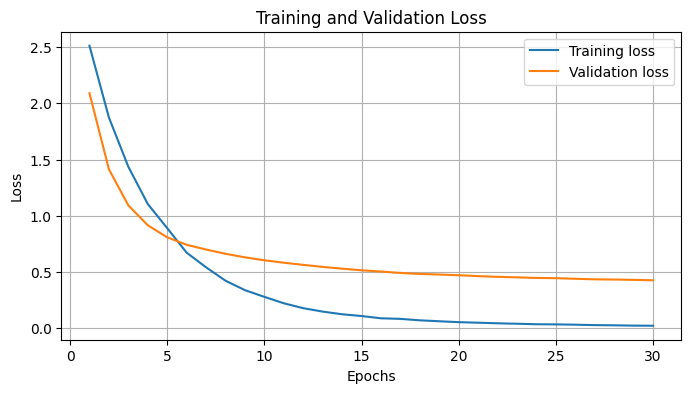

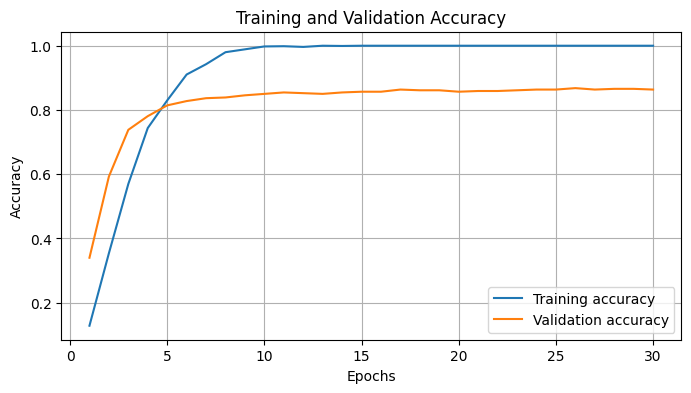

In [17]:
loss      = best_history['loss']
val_loss  = best_history.get('val_loss')
acc       = best_history.get('accuracy') or best_history.get('acc')
val_acc   = best_history.get('val_accuracy') or best_history.get('val_acc')

epochs = range(1, len(loss) + 1)

# Courbe de loss
plt.figure(figsize=(8,4))
plt.plot(epochs, loss,    label='Training loss')
if val_loss is not None:
    plt.plot(epochs, val_loss, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Courbe d’accuracy
if acc is not None:
    plt.figure(figsize=(8,4))
    plt.plot(epochs, acc,    label='Training accuracy')
    if val_acc is not None:
        plt.plot(epochs, val_acc, label='Validation accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

# Matrice de confusion

14/14 ━━━━━━━━━━━━━━━━━━━━ 14s 615ms/step


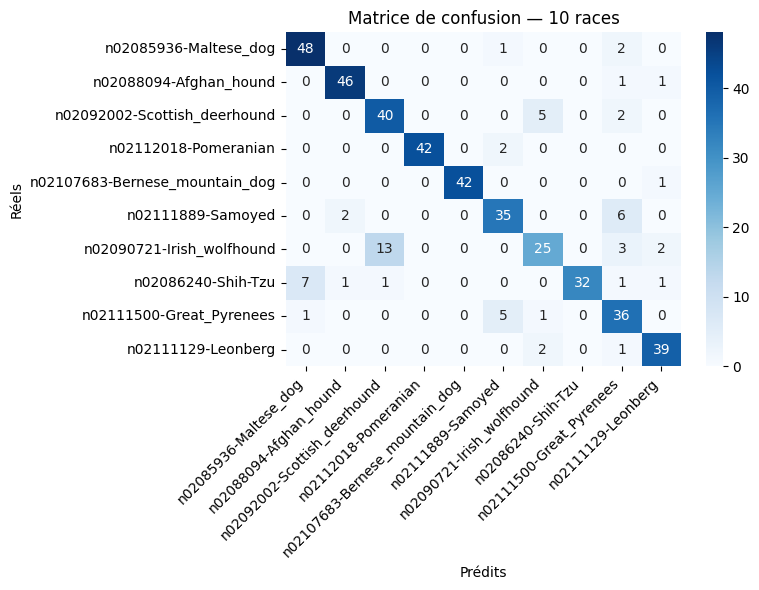

In [18]:
y_prob = best_model.predict(val_ds)            # shape (N, num_classes)
y_pred = np.argmax(y_prob, axis=1)        # shape (N,)

# 2) labels vrais
y_true = np.concatenate([y.numpy() for _, y in val_ds], axis=0)

# 3) matrice de confusion
cm = confusion_matrix(y_true, y_pred)

# 3) Affichage avec heatmap
plt.figure(figsize=(8,6))
sns.heatmap(
    cm,
    annot=True, fmt="d", cmap="Blues",
    xticklabels=top10, yticklabels=top10
)
plt.xlabel("Prédits")
plt.ylabel("Réels")
plt.title("Matrice de confusion — 10 races")
plt.xticks(rotation=45, ha="right")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

In [19]:
!pip install h5py

In [20]:
best_model.save('mon_modele.h5', include_optimizer=False)